# Comparison: GD vs Maxvol approach for approximation (1-D case)
We need to compare approaches in the following sences:
* **Condition number** or/and **determinant** of the resulting matrix $A$ 

* Analytically derive a gradient of squared volume of $A$: $\nabla(\det(A^{*}A))$, and use it in GD 
* ...
* Profit!

In [641]:
import numpy as np
import numpy.linalg as LA
from numpy.polynomial import Chebyshev as T
from scipy import optimize
from maxvolpy.maxvol import maxvol
import matplotlib.pyplot as plt
from maxvolpy.maxvol import rect_maxvol
%matplotlib inline

In [642]:
# generate polynomial matrix 
def gen_mat(points, degree):
    num_of_columns = degree + 1
    A = np.zeros((len(points), num_of_columns), dtype = np.float64)
    for i in range(num_of_columns):
        #A[:, i] = points[:]**i #uncomment for the monomial case
        A[:, i] = T.basis(i)(points[:]) #uncomment for Chebyshev polynomials
    return A

In [643]:
# plotting and errors of approximation

def plot_and_err(x_gd, x_new_gd, x_maxvol, interval):
    
    # solution to the linear system
#     c_gd = LA.solve(gen_mat(x_gd, degree), f(x_gd))
#     c_maxvol = LA.solve(gen_mat(x_maxvol, degree), f(x_maxvol))
#     c_new_gd = LA.solve(gen_mat(x_new_gd, degree), f(x_new_gd))
    
    A_gd = gen_mat(x_gd, degree)
    c_gd = LA.solve(np.dot(A_gd.conj().T, A_gd), np.dot(A_gd.conj().T, f(x_gd)))
    A_maxvol = gen_mat(x_maxvol, degree)
    c_maxvol = LA.solve(np.dot(A_maxvol.conj().T, A_maxvol), np.dot(A_maxvol.conj().T, f(x_maxvol)))
    A_new_gd = gen_mat(x_new_gd, degree)
    c_new_gd = LA.solve(np.dot(A_new_gd.conj().T, A_new_gd), np.dot(A_new_gd.conj().T, f(x_new_gd)))

    
    rhs = f(interval)
    rhs_gd = np.polynomial.chebyshev.chebval(interval, c_gd)
    rhs_new_gd = np.polynomial.chebyshev.chebval(interval, c_new_gd)
    rhs_maxvol = np.polynomial.chebyshev.chebval(interval, c_maxvol)
    
    # error estimation
    err_maxvol = round((LA.norm(rhs - rhs_maxvol, 2) / LA.norm(rhs, 2)), 4)
    err_gd = round((LA.norm(rhs - rhs_gd, 2) / LA.norm(rhs, 2)), 4)
    err_new_gd = round((LA.norm(rhs - rhs_new_gd, 2) / LA.norm(rhs, 2)), 4)
    
    # plotting
    __ , axarr = plt.subplots(1, 4, figsize=(20, 5))
    
    axarr[0].grid(True)
    axarr[0].plot(interval, rhs, 'b', interval, rhs_maxvol, 'r--', x_maxvol, f(x_maxvol), 'go')
    axarr[0].set_title('Maxvol error = ' + str(err_maxvol))
    axarr[0].set_xlabel("X")
    axarr[0].set_ylabel("f(X)")
    
    axarr[1].grid(True)
    axarr[1].plot(interval, rhs, 'b', interval, rhs_gd, 'r--', x_gd, f(x_gd), 'go')
    axarr[1].set_title('GD error = ' + str(err_gd))
    axarr[1].set_xlabel("X")
    axarr[1].set_ylabel("f(X)")
    
    axarr[2].grid(True)
    axarr[2].plot(interval, rhs, 'b', interval, rhs_new_gd, 'r--', x_new_gd, f(x_new_gd), 'go')
    axarr[2].set_title('NEW GD error = ' + str(err_new_gd))
    axarr[2].set_xlabel("X")
    axarr[2].set_ylabel("f(X)")
    
    axarr[3].grid(True)
    axarr[3].plot(range(len(x_0)), np.sort(opt[0]), 'g^', range(len(x_0)), np.sort(mat[row_indx, 1]), 'ro', label = ["asdas","d"])
    axarr[3].set_title('NEW GD vs Maxvol')
    axarr[3].set_xlabel("N – point number")
    axarr[3].set_ylabel("X")

    plt.show()

# approximated function
def f(x):
    return np.exp(x)*np.sin(x)#(x**8 - x**5 + x**3 - 1)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# 

#### Workspace

In [644]:
degree = 6
left = -1.1
right = 7.9
num_points = 9 # num_points > degree 

x_0 = np.linspace(left, right, num_points) 
x_big = np.linspace(left, right, 1000000) 

bnds = tuple((left, right) for i in x_0)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# 

#### Maxvol

In [645]:
mat = gen_mat(x_big, degree)
#row_indx, _ = maxvol(mat, tol = 1, max_iters = 1000000)
row_indx, _ = rect_maxvol(mat, tol = 1.0, minK = num_points, maxK = num_points)
print(np.sort(mat[row_indx, 1]), '\n Cond_num = ', LA.cond(mat[row_indx]))

[-1.1        -0.51503234 -0.19783991  1.24663593  3.39999955  5.51846116
  7.09719722  7.17664383  7.9       ] 
 Cond_num =  7435399.02078


 #-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# 
 
 
 
 
 

## Objective function is a condition number of matrix $A$

#### Gradient Descent

In [646]:
# calculation of condition number
# LOSS FUNCTION 
def cond_handmade(points):
    matrix = gen_mat(points, degree)
    return ((LA.norm(matrix, 2) * LA.norm(LA.pinv(matrix), 2)) / LA.norm(matrix, 1)**2)

In [647]:
res = optimize.fmin_l_bfgs_b(cond_handmade, x_0, approx_grad = 1, factr = 10.0, bounds = bnds)
print(np.sort(res[0]), '\n Cond_num = ', res[1])

[-1.1    0.025  1.15   2.275  3.4    4.525  5.65   6.775  7.9  ] 
 Cond_num =  5.23550045744e-08


In [648]:
LA.cond(gen_mat(np.sort(res[0]), degree))

7390754.129165628

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------# 

## Objective function is a determinant of the squared volume of matrix $A$

In [649]:
LA.cond(gen_mat(np.sort(res[0]), degree))

7390754.129165628

In [650]:
def grad_of_det(points):
    A = gen_mat(points, degree)
    grad = np.zeros(len(points))
    B_inv = LA.inv(np.dot(A.conj().T, A))
    for k in range(len(grad)):
        for i in range(B_inv.shape[0]):
            for j in range(B_inv.shape[0]):            
                grad[k] += B_inv[j,i] * (T.deriv(T.basis(i))(points[k])*T.basis(j)(points[k]) +
                                         T.basis(i)(points[k])*T.deriv(T.basis(j))(points[k]))
    return -grad 
#------------------------------------------------------------------------------------------------
def loss_det(points):
    A = gen_mat(points, degree)
    S = LA.svd(A, compute_uv = False)
    det = np.prod(S)**2
    
    return np.log(det)

In [651]:
grad_of_det(x_0)

array([  3.77085038e+00,   1.23931969e+00,  -1.15355262e-01,
         9.60165761e-02,  -1.62039271e-11,  -9.60165760e-02,
         1.15355262e-01,  -1.23931969e+00,  -3.77085038e+00])

In [652]:
optimize.minimize(lambda x: -loss_det(x), x_0, jac = grad_of_det, bounds = bnds)

      fun: -75.195350443896857
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.66666801e+00,  -1.02502781e-05,   7.56578090e-06,
         8.61823762e-06,   3.81134118e-07,  -8.88571230e-06,
        -6.12864551e-06,   2.48721335e-06,  -4.66666180e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 12
   status: 0
  success: True
        x: array([-1.1       , -0.36942444,  0.89209356,  1.71436889,  3.40000011,
        5.08563104,  5.90790673,  7.16942267,  7.9       ])

In [653]:
opt = optimize.fmin_l_bfgs_b(lambda x: -loss_det(x), x_0, fprime = grad_of_det, factr = 10.0, bounds = bnds)
opt

(array([-1.1       , -0.36942394,  0.8920799 ,  1.71434317,  3.40000003,
         5.08565682,  5.90792007,  7.16942394,  7.9       ]),
 -75.195350444453467,
 {'funcalls': 17,
  'grad': array([  4.66666701e+00,  -4.03497744e-07,   3.81409397e-08,
          -8.80286387e-08,   3.84905050e-08,   6.42985469e-08,
          -5.79029802e-08,   4.30736691e-07,  -4.66666703e+00]),
  'nit': 13,
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [654]:
print('GD\n',np.sqrt(LA.det(np.dot(gen_mat(opt[0], degree).conj().T, gen_mat(opt[0], degree)))),'\n', gen_mat(opt[0], degree).shape)
print('Maxvol\n',np.sqrt(LA.det(np.dot(mat[row_indx].conj().T, mat[row_indx]))),'\n', mat[row_indx].shape)

GD
 2.13040847677e+16 
 (9, 7)
Maxvol
 2.07756103907e+16 
 (9, 7)


In [655]:
print(optimize.check_grad(loss_det, grad_of_det, x_0),'\n',
optimize.approx_fprime(x_0, loss_det, epsilon = 1e-10))

11.2415265293 
 [-3.02023295 -1.0042811   0.14551915 -0.07403855  2.19785079  0.25025315
 -1.05657705  2.44028797  1.6177637 ]


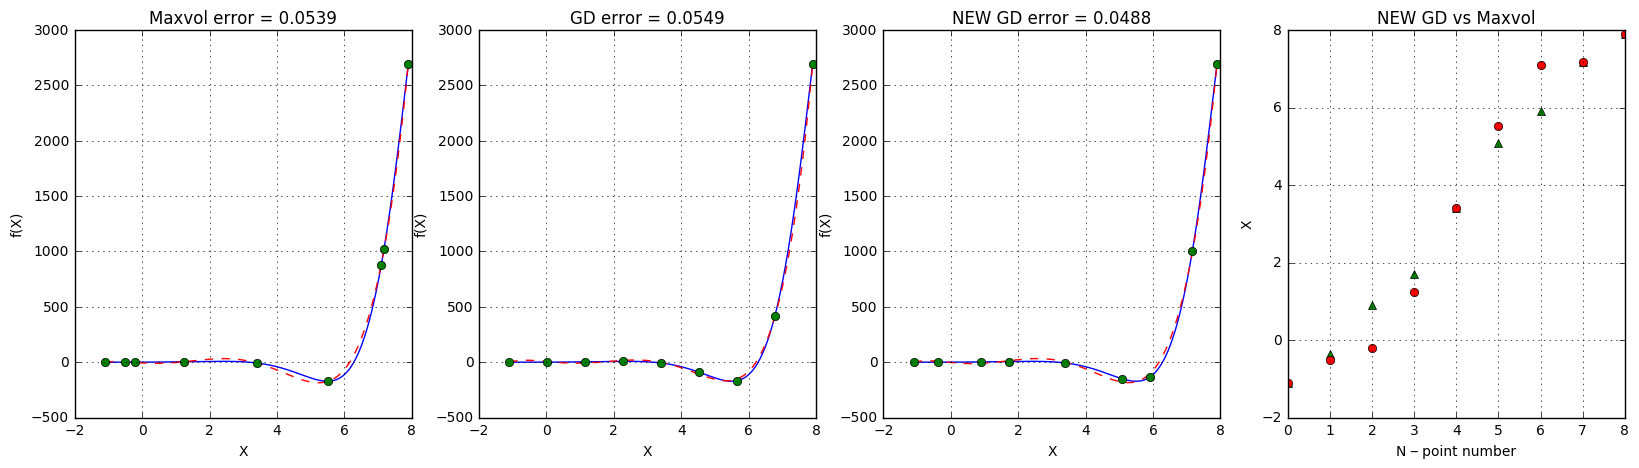

In [656]:
plot_and_err(np.sort(res[0]), np.sort(opt[0]), np.sort(mat[row_indx, 1]), x_big)